In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import classification_report, accuracy_score
from subprocess import check_call
from sklearn.tree import export_graphviz
import operator
from dtreeviz.trees import *
from sklearn.datasets import load_iris
# from IPython import display

import sys
sys.path.append('..')

from Libraries.Utils.Global_Utils import *
from Libraries.ClusterMaster import *
from Libraries.DataframeTypeHolder import *
%matplotlib inline

In [2]:
def replace_df_vals(passed_df,replace_dict):
    """
        Uses a hash map to decode dataframe data
    """

    def replace_vals_col(data, decoder):
        return decoder[data]

    df = copy.deepcopy(passed_df)
    for col in df.columns:
        if col in replace_dict.keys():
            df[col] = np.vectorize(replace_vals_col)(
                df[col], replace_dict[col])

    return df

# Returns encoded df and label encoded map
def encode_df(df, objt_cols):

    df = copy.deepcopy(df)
    # ---
    le_map = defaultdict(LabelEncoder)

    # Encoding the variable
    fit = df[objt_cols].apply(lambda x: le_map[x.name].fit_transform(x))

    # Inverse the encoded
    fit.apply(lambda x: le_map[x.name].inverse_transform(x))

    # Using the dictionary to label future data
    df[objt_cols] = df[objt_cols].apply(lambda x: le_map[x.name].transform(x))

    return df, le_map

def decode_df(df,le_map):
    
    df = copy.deepcopy(df)
    decode_cols = list(le_map.keys())
    df[decode_cols] = df[decode_cols].apply(lambda x: le_map[x.name].inverse_transform(x))
    
    return df


def print_encode_map(le):

    print("\nLabel mapping:\n")
    for i, item in enumerate(le.classes_):
        print("\t", item, '-->', i)

    # Draw a line
    print("-"*30, "\n")

In [3]:
iris = load_iris()

In [4]:
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['species'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
# http://archive.ics.uci.edu/ml/datasets/Heart+Disease
replace_dict = dict()

replace_dict["species"] = {0:"Setosa",
                           1:"Versicolor",
                           2:"Virginica"}

iris_df = replace_df_vals(iris_df,replace_dict)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [6]:
df_features = DataframeTypeHolder(iris_df)
df_features.display_all()

Categorical Features: {'species'}

Bool Features: set()

------------------------------------------------------------------------------------------
Numerical Features: {'sepal width (cm)', 'sepal length (cm)', 'petal length (cm)', 'petal width (cm)'}

Integer Features: set()

Float Features: {'sepal width (cm)', 'sepal length (cm)', 'petal length (cm)', 'petal width (cm)'}



In [7]:
iris_df, le_map = encode_df(iris_df, df_features.get_categorical_features())
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
restore_df = iris_df
iris_df = iris_df.drop(columns=['species'])

In [9]:
iris_df.values.shape

(150, 4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1,-0.11757,0.871754,0.817941
sepal width (cm),-0.11757,1,-0.42844,-0.366126
petal length (cm),0.871754,-0.42844,1,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1


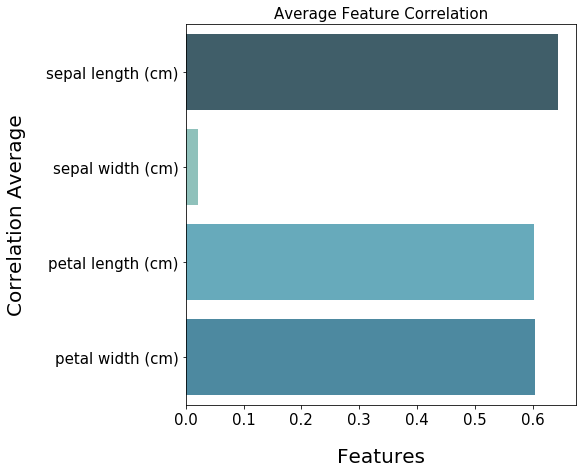

In [10]:
corr_metrics = iris_df.corr()
display(corr_metrics.style.background_gradient())

# Get the correlation means of each feature
corr_feature_means = []
for feature_name in list(corr_metrics.columns):
    corr_feature_means.append(corr_metrics[feature_name].mean())

# Graph rank
display_rank_graph(feature_names=list(corr_metrics.columns),
                   metric=corr_feature_means,
                   title="Average Feature Correlation",
                   y_title="Correlation Average",
                   x_title="Features")


Inspecting scaled results!


,Mean,Standard Dev
sepal length (cm),-4.736952e-16,1.0
sepal width (cm),-7.815970e-16,1.0
petal length (cm),-4.263256e-16,1.0
petal width (cm),-4.736952e-16,1.0


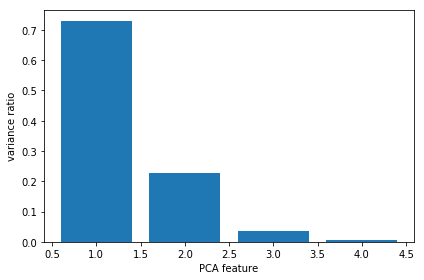

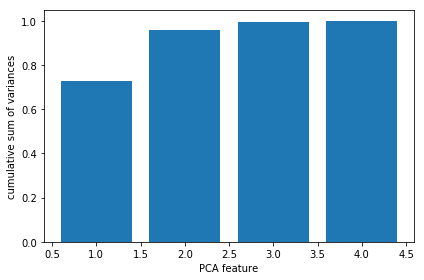


Inspecting applied pca results!


,Mean,Standard Dev
PCA_Feature_1,2.842171e-16,1.708361
PCA_Feature_2,3.848773e-17,0.956049
PCA_Feature_3,4.144833e-17,0.383089
PCA_Feature_4,6.809368e-17,0.143926


After applying pca with a cutoff percentage 0.8% for the cumulative index. Using features 1 to 2
Old shape (150, 4)
New shape (150, 2)

Inspecting re-applied scaled results!


,Mean,Standard Dev
PCA_Feature_1,-4.736952e-17,1.0
PCA_Feature_2,2.960595e-18,1.0


In [11]:
cluster_maintainer = ClusterMaster(df=iris_df,
                                   pca_perc=.8)

Successfully generate Kmeans model on k_val=2
Successfully generate Kmeans model on k_val=3
Successfully generate Kmeans model on k_val=4


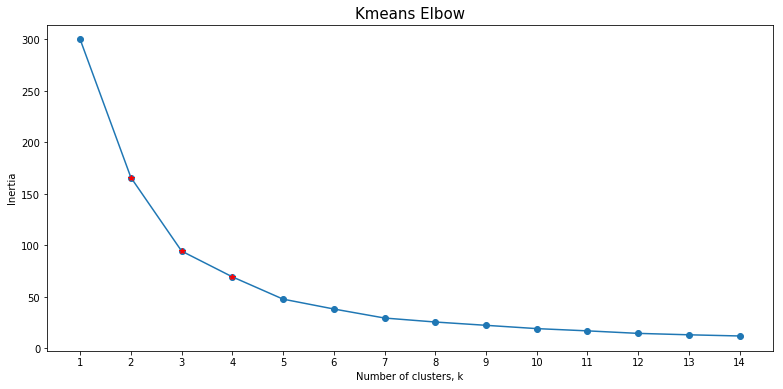

In [12]:
cluster_maintainer.create_kmeans_models_with_elbow_graph()

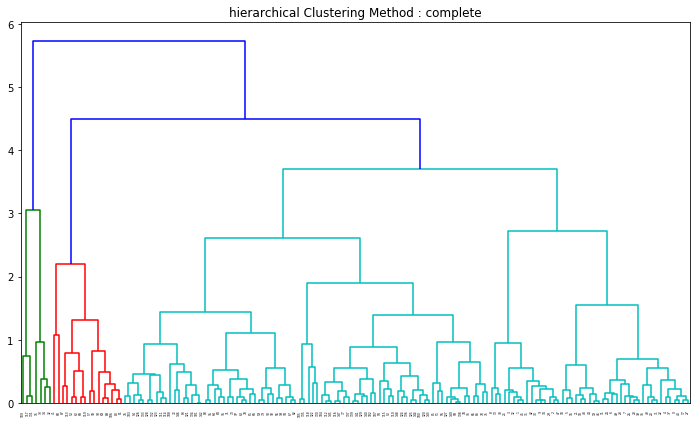

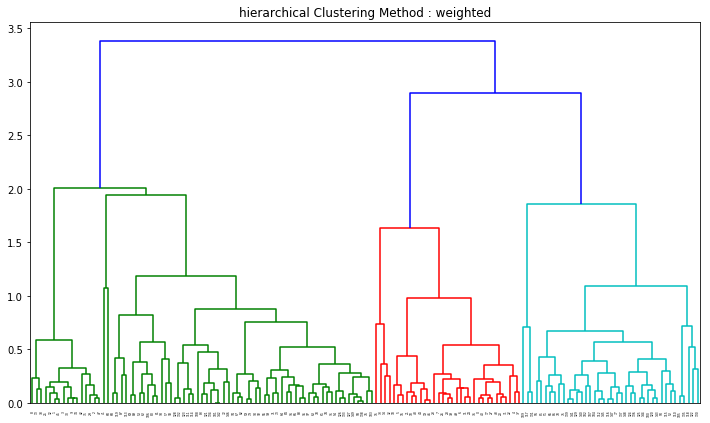

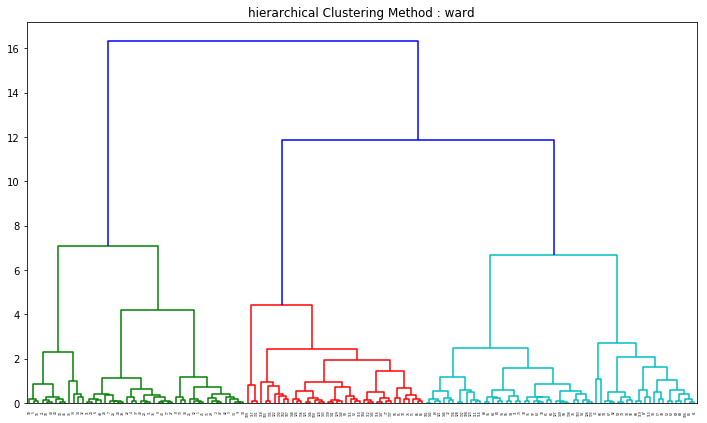

In [13]:
cluster_maintainer.visualize_hierarchical_clustering(linkage_methods=["complete","weighted","ward"])

In [14]:
# cluster_maintainer.create_agglomerative_models(n_cluster_list=5)

In [15]:
cluster_maintainer.create_kmeans_models(n_cluster_list=[8,12])

Successfully generate Kmeans model on pre_defined_k=8
Successfully generate Kmeans model on pre_defined_k=12


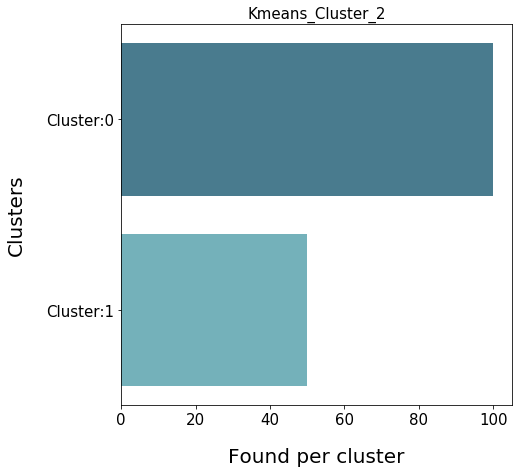

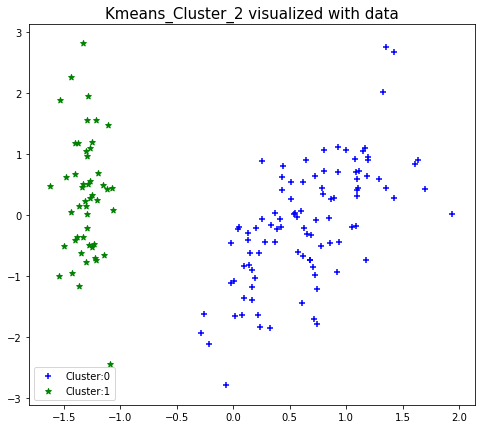









Total found in Cluster:0 is 86


/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,6.2,2.9,4.9,1.7,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.216279,2.890698,4.852326,1.667442,1.476744
Min,5.000000,2.300000,3.300000,1.000000,1.000000
Median,6.300000,2.900000,4.850000,1.600000,1.000000
Max,7.400000,3.400000,6.300000,2.500000,2.000000
Standard Deviation,0.519017,0.264632,0.681819,0.405388,0.502388
Variance,0.269379,0.070030,0.464877,0.164339,0.252394









Total found in Cluster:1 is 40


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,5.0,3.4,1.5,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.997500,3.397500,1.462500,0.230000,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,5.000000,3.400000,1.500000,0.200000,0.0
Max,5.700000,4.100000,1.700000,0.400000,0.0
Standard Deviation,0.310077,0.299133,0.121291,0.082275,0.0
Variance,0.096147,0.089481,0.014712,0.006769,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  126
Shrank by:  24


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,4.9,1.7,6.2,2.9,Versicolor
Cluster:1,1.5,0.2,5.0,3.4,Setosa







--------------------------------------------------------------------------------


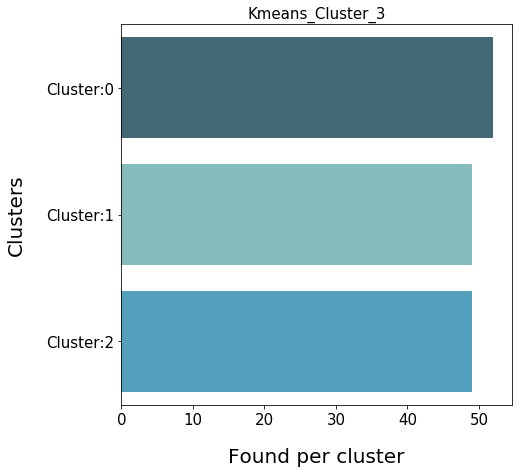

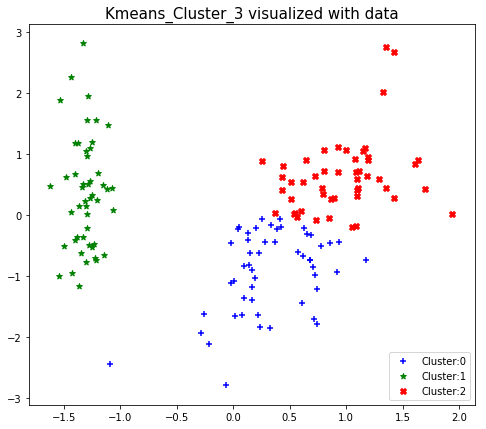









Total found in Cluster:0 is 48


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,5.8,2.7,4.4,1.4,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.802083,2.660417,4.358333,1.397917,1.250000
Min,4.900000,2.200000,3.000000,1.000000,1.000000
Median,5.800000,2.700000,4.350000,1.300000,1.000000
Max,6.500000,3.000000,5.600000,2.000000,2.000000
Standard Deviation,0.399196,0.231314,0.566375,0.284709,0.437595
Variance,0.159357,0.053506,0.320780,0.081059,0.191489









Total found in Cluster:1 is 40


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,5.0,3.4,1.5,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.997500,3.397500,1.462500,0.230000,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,5.000000,3.400000,1.500000,0.200000,0.0
Max,5.700000,4.100000,1.700000,0.400000,0.0
Standard Deviation,0.310077,0.299133,0.121291,0.082275,0.0
Variance,0.096147,0.089481,0.014712,0.006769,0.0









Total found in Cluster:2 is 45


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,6.7,3.1,5.4,1.9,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.660000,3.075556,5.353333,1.917778,1.711111
Min,5.900000,2.800000,4.400000,1.300000,1.000000
Median,6.700000,3.000000,5.400000,1.900000,2.000000
Max,7.700000,3.400000,6.700000,2.500000,2.000000
Standard Deviation,0.452970,0.165359,0.590300,0.345943,0.458368
Variance,0.205182,0.027343,0.348455,0.119677,0.210101









Orginal points in dataframe:  150
Total points in all modified clusters:  133
Shrank by:  17


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,4.4,1.4,5.8,2.7,Versicolor
Cluster:1,1.5,0.2,5.0,3.4,Setosa
Cluster:2,5.4,1.9,6.7,3.1,Virginica







--------------------------------------------------------------------------------


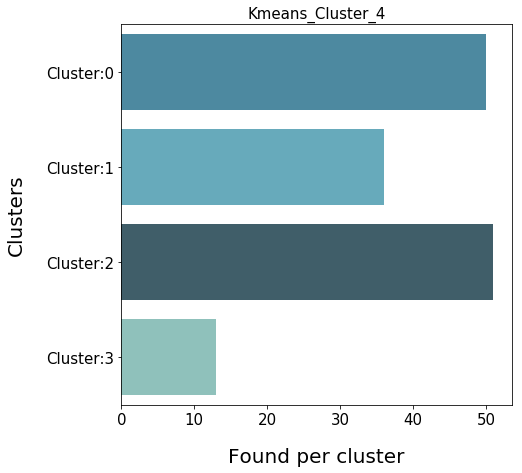

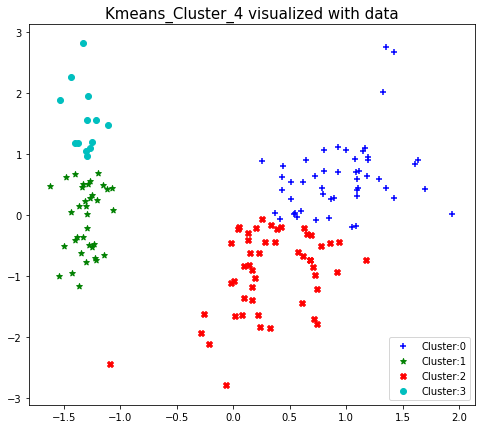









Total found in Cluster:0 is 46


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,6.7,3.1,5.3,1.9,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.654348,3.071739,5.330435,1.904348,1.695652
Min,5.900000,2.800000,4.300000,1.300000,1.000000
Median,6.650000,3.000000,5.400000,1.850000,2.000000
Max,7.700000,3.400000,6.700000,2.500000,2.000000
Standard Deviation,0.449546,0.165547,0.604012,0.353997,0.465215
Variance,0.202092,0.027406,0.364831,0.125314,0.216425









Total found in Cluster:1 is 30


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,4.9,3.3,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.890000,3.266667,1.446667,0.216667,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,4.900000,3.250000,1.400000,0.200000,0.0
Max,5.400000,3.600000,1.700000,0.400000,0.0
Standard Deviation,0.263072,0.203983,0.113664,0.069893,0.0
Variance,0.069207,0.041609,0.012920,0.004885,0.0









Total found in Cluster:2 is 47


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,5.8,2.7,4.4,1.4,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.789362,2.655319,4.359574,1.400000,1.255319
Min,4.900000,2.200000,3.000000,1.000000,1.000000
Median,5.800000,2.700000,4.400000,1.300000,1.000000
Max,6.500000,3.000000,5.600000,2.000000,2.000000
Standard Deviation,0.393554,0.231074,0.572432,0.287417,0.440755
Variance,0.154884,0.053395,0.327678,0.082609,0.194265









Total found in Cluster:3 is 11


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:3,5.4,3.9,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.363636,3.872727,1.490909,0.263636,0.0
Min,5.100000,3.700000,1.200000,0.100000,0.0
Median,5.400000,3.800000,1.500000,0.200000,0.0
Max,5.800000,4.200000,1.700000,0.400000,0.0
Standard Deviation,0.237793,0.167874,0.151357,0.102691,0.0
Variance,0.056545,0.028182,0.022909,0.010545,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  134
Shrank by:  16


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,5.3,1.9,6.7,3.1,Virginica
Cluster:1,1.4,0.2,4.9,3.3,Setosa
Cluster:2,4.4,1.4,5.8,2.7,Versicolor
Cluster:3,1.5,0.3,5.4,3.9,Setosa







--------------------------------------------------------------------------------


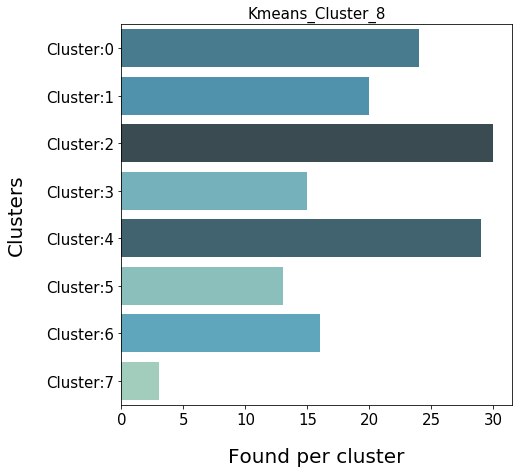

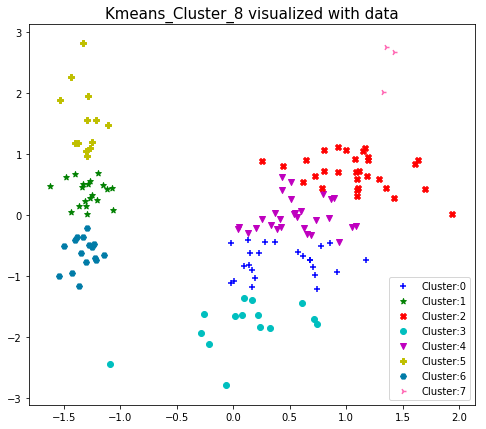









Total found in Cluster:0 is 21


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,5.9,2.7,4.5,1.5,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.857143,2.695238,4.514286,1.457143,1.333333
Min,5.500000,2.500000,3.500000,1.000000,1.000000
Median,5.800000,2.700000,4.500000,1.300000,1.000000
Max,6.300000,2.900000,5.600000,2.000000,2.000000
Standard Deviation,0.250143,0.120317,0.569461,0.327981,0.483046
Variance,0.062571,0.014476,0.324286,0.107571,0.233333









Total found in Cluster:1 is 17


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,5.1,3.4,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.082353,3.441176,1.470588,0.252941,0.0
Min,4.600000,3.300000,1.300000,0.100000,0.0
Median,5.100000,3.400000,1.400000,0.200000,0.0
Max,5.500000,3.600000,1.700000,0.500000,0.0
Standard Deviation,0.221459,0.087026,0.121268,0.100733,0.0
Variance,0.049044,0.007574,0.014706,0.010147,0.0









Total found in Cluster:2 is 28


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,6.8,3.1,5.6,2.1,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.814286,3.125000,5.600000,2.060714,1.857143
Min,6.000000,2.800000,4.500000,1.500000,1.000000
Median,6.750000,3.100000,5.650000,2.100000,2.000000
Max,7.700000,3.400000,6.700000,2.500000,2.000000
Standard Deviation,0.456001,0.166944,0.543650,0.307124,0.356348
Variance,0.207937,0.027870,0.295556,0.094325,0.126984









Total found in Cluster:3 is 13


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:3,5.5,2.4,4.0,1.2,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.538462,2.361538,3.953846,1.223077,1.153846
Min,4.900000,2.200000,3.000000,1.000000,1.000000
Median,5.500000,2.400000,4.000000,1.100000,1.000000
Max,6.300000,2.500000,5.000000,1.700000,2.000000
Standard Deviation,0.478781,0.119293,0.559189,0.231495,0.375534
Variance,0.229231,0.014231,0.312692,0.053590,0.141026









Total found in Cluster:4 is 24


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:4,6.2,2.9,4.7,1.6,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.237500,2.937500,4.741667,1.562500,1.375000
Min,5.600000,2.800000,4.100000,1.200000,1.000000
Median,6.250000,3.000000,4.650000,1.500000,1.000000
Max,6.800000,3.100000,5.600000,2.100000,2.000000
Standard Deviation,0.347428,0.087539,0.438294,0.246387,0.494535
Variance,0.120707,0.007663,0.192101,0.060707,0.244565









Total found in Cluster:5 is 11


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:5,5.4,3.9,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.363636,3.872727,1.490909,0.263636,0.0
Min,5.100000,3.700000,1.200000,0.100000,0.0
Median,5.400000,3.800000,1.500000,0.200000,0.0
Max,5.800000,4.200000,1.700000,0.400000,0.0
Standard Deviation,0.237793,0.167874,0.151357,0.102691,0.0
Variance,0.056545,0.028182,0.022909,0.010545,0.0









Total found in Cluster:6 is 14


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:6,4.7,3.1,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.721429,3.092857,1.428571,0.185714,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,4.750000,3.100000,1.400000,0.200000,0.0
Max,5.000000,3.200000,1.600000,0.200000,0.0
Standard Deviation,0.215473,0.099725,0.126665,0.036314,0.0
Variance,0.046429,0.009945,0.016044,0.001319,0.0









Total found in Cluster:7 is 3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:7,7.6,3.7,6.4,2.2,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,7.600000,3.733333,6.40,2.233333,2.0
Min,7.200000,3.600000,6.10,2.000000,2.0
Median,7.700000,3.800000,6.40,2.200000,2.0
Max,7.900000,3.800000,6.70,2.500000,2.0
Standard Deviation,0.360555,0.115470,0.30,0.251661,0.0
Variance,0.130000,0.013333,0.09,0.063333,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  131
Shrank by:  19


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,4.5,1.5,5.9,2.7,Versicolor
Cluster:1,1.5,0.3,5.1,3.4,Setosa
Cluster:2,5.6,2.1,6.8,3.1,Virginica
Cluster:3,4.0,1.2,5.5,2.4,Versicolor
Cluster:4,4.7,1.6,6.2,2.9,Versicolor
Cluster:5,1.5,0.3,5.4,3.9,Setosa
Cluster:6,1.4,0.2,4.7,3.1,Setosa
Cluster:7,6.4,2.2,7.6,3.7,Virginica







--------------------------------------------------------------------------------


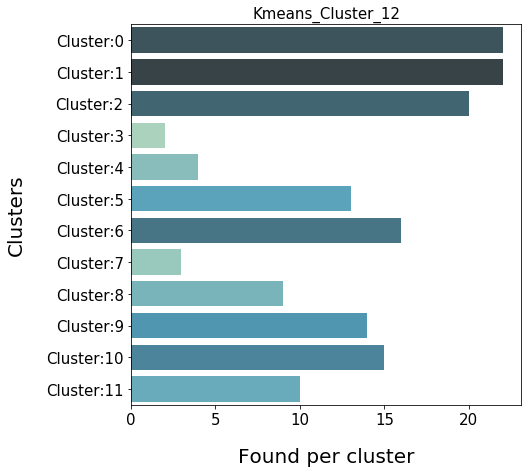

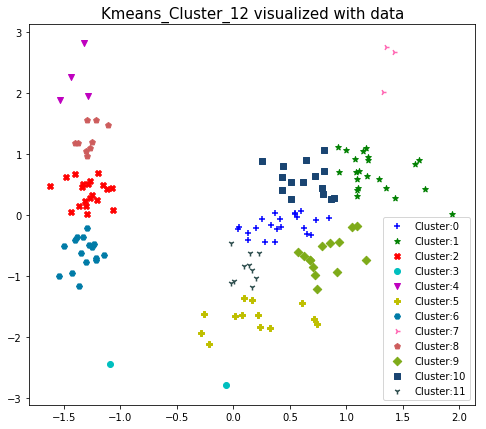









Total found in Cluster:0 is 19


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:0,6.1,2.9,4.5,1.5,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.057895,2.915789,4.536842,1.457895,1.263158
Min,5.600000,2.800000,4.000000,1.200000,1.000000
Median,6.100000,2.900000,4.600000,1.400000,1.000000
Max,6.600000,3.000000,5.100000,1.800000,2.000000
Standard Deviation,0.283462,0.083421,0.325253,0.206332,0.452414
Variance,0.080351,0.006959,0.105789,0.042573,0.204678









Total found in Cluster:1 is 20


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:1,6.9,3.1,5.8,2.2,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.930000,3.095000,5.810000,2.190000,2.0
Min,6.300000,2.800000,5.100000,1.800000,2.0
Median,6.850000,3.100000,5.750000,2.250000,2.0
Max,7.700000,3.400000,6.700000,2.500000,2.0
Standard Deviation,0.435407,0.166938,0.425379,0.207491,0.0
Variance,0.189579,0.027868,0.180947,0.043053,0.0









Total found in Cluster:2 is 17


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:2,5.1,3.4,1.5,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.082353,3.441176,1.470588,0.252941,0.0
Min,4.600000,3.300000,1.300000,0.100000,0.0
Median,5.100000,3.400000,1.400000,0.200000,0.0
Max,5.500000,3.600000,1.700000,0.500000,0.0
Standard Deviation,0.221459,0.087026,0.121268,0.100733,0.0
Variance,0.049044,0.007574,0.014706,0.010147,0.0









Total found in Cluster:3 is 2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:3,4.8,2.2,1.9,0.5,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.750000,2.150000,2.400000,0.650000,0.500000
Min,4.500000,2.000000,1.300000,0.300000,0.000000
Median,4.750000,2.150000,2.400000,0.650000,0.500000
Max,5.000000,2.300000,3.500000,1.000000,1.000000
Standard Deviation,0.353553,0.212132,1.555635,0.494975,0.707107
Variance,0.125000,0.045000,2.420000,0.245000,0.500000









Total found in Cluster:4 is 4


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:4,5.5,4.2,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.550000,4.175000,1.400000,0.225000,0.0
Min,5.200000,4.000000,1.200000,0.100000,0.0
Median,5.600000,4.150000,1.450000,0.200000,0.0
Max,5.800000,4.400000,1.500000,0.400000,0.0
Standard Deviation,0.264575,0.170783,0.141421,0.125831,0.0
Variance,0.070000,0.029167,0.020000,0.015833,0.0









Total found in Cluster:5 is 12


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:5,5.6,2.4,3.9,1.2,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.591667,2.350000,3.908333,1.183333,1.083333
Min,4.900000,2.200000,3.000000,1.000000,1.000000
Median,5.500000,2.350000,3.950000,1.100000,1.000000
Max,6.300000,2.500000,5.000000,1.500000,2.000000
Standard Deviation,0.458175,0.116775,0.558339,0.189896,0.288675
Variance,0.209924,0.013636,0.311742,0.036061,0.083333









Total found in Cluster:6 is 14


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:6,4.7,3.1,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,4.721429,3.092857,1.428571,0.185714,0.0
Min,4.400000,2.900000,1.200000,0.100000,0.0
Median,4.750000,3.100000,1.400000,0.200000,0.0
Max,5.000000,3.200000,1.600000,0.200000,0.0
Standard Deviation,0.215473,0.099725,0.126665,0.036314,0.0
Variance,0.046429,0.009945,0.016044,0.001319,0.0









Total found in Cluster:7 is 3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:7,7.6,3.7,6.4,2.2,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,7.600000,3.733333,6.40,2.233333,2.0
Min,7.200000,3.600000,6.10,2.000000,2.0
Median,7.700000,3.800000,6.40,2.200000,2.0
Max,7.900000,3.800000,6.70,2.500000,2.0
Standard Deviation,0.360555,0.115470,0.30,0.251661,0.0
Variance,0.130000,0.013333,0.09,0.063333,0.0









Total found in Cluster:8 is 8


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:8,5.2,3.8,1.6,0.3,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.237500,3.787500,1.562500,0.312500,0.0
Min,5.100000,3.700000,1.300000,0.200000,0.0
Median,5.200000,3.800000,1.500000,0.350000,0.0
Max,5.400000,3.900000,1.900000,0.400000,0.0
Standard Deviation,0.150594,0.083452,0.176777,0.099103,0.0
Variance,0.022679,0.006964,0.031250,0.009821,0.0









Total found in Cluster:9 is 13


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:9,6.1,2.7,5.2,1.8,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.138462,2.653846,5.223077,1.846154,1.846154
Min,5.600000,2.500000,4.900000,1.400000,1.000000
Median,6.300000,2.700000,5.100000,1.900000,2.000000
Max,6.700000,2.800000,5.800000,2.200000,2.000000
Standard Deviation,0.333013,0.119829,0.319254,0.229548,0.375534
Variance,0.110897,0.014359,0.101923,0.052692,0.141026









Total found in Cluster:10 is 14


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:10,6.5,3.1,4.9,1.6,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,6.507143,3.135714,4.850000,1.642857,1.285714
Min,5.900000,3.000000,4.400000,1.400000,1.000000
Median,6.500000,3.100000,4.750000,1.600000,1.000000
Max,7.000000,3.400000,5.500000,2.000000,2.000000
Standard Deviation,0.304995,0.121574,0.369511,0.210180,0.468807
Variance,0.093022,0.014780,0.136538,0.044176,0.219780









Total found in Cluster:11 is 8


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Cluster:11,5.7,2.7,4.1,1.2,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
Mean,5.700000,2.687500,4.087500,1.187500,1.0
Min,5.500000,2.600000,3.500000,1.000000,1.0
Median,5.700000,2.700000,4.100000,1.200000,1.0
Max,5.800000,2.800000,4.500000,1.300000,1.0
Standard Deviation,0.106904,0.083452,0.309089,0.124642,0.0
Variance,0.011429,0.006964,0.095536,0.015536,0.0









Orginal points in dataframe:  150
Total points in all modified clusters:  134
Shrank by:  16


,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),species
Cluster:0,4.5,1.5,6.1,2.9,Versicolor
Cluster:1,5.8,2.2,6.9,3.1,Virginica
Cluster:2,1.5,0.3,5.1,3.4,Setosa
Cluster:3,1.9,0.5,4.8,2.2,Versicolor
Cluster:4,1.4,0.2,5.5,4.2,Setosa
Cluster:5,3.9,1.2,5.6,2.4,Versicolor
Cluster:6,1.4,0.2,4.7,3.1,Setosa
Cluster:7,6.4,2.2,7.6,3.7,Virginica
Cluster:8,1.6,0.3,5.2,3.8,Setosa
Cluster:9,5.2,1.8,6.1,2.7,Virginica







--------------------------------------------------------------------------------


In [16]:
cluster_maintainer.evaluate_all_models(restore_df,
                                       df_features,
                                       le_map,
                                       zscore_low=-2,
                                       zscore_high=2,
                                       find_nearest_on_cols=True)